# Detect Pneumonia using X-ray Images with CNNs and Transfer Learning

[Pneumonia](https://www.healthline.com/health/pneumonia) is an infection caused by bacteria, viruses, or fungi. It leads to inflammation in the air sacs of one or both lungs. These sacs, called alveoli, fill with fluid or pus, making it difficult to breathe.

According to the [World Health Organization (WHO)](https://www.who.int/health-topics/pneumonia#tab=tab_1),Pneumonia killed more than 808 000 children under the age of 5 in 2017, accounting for 15% of all deaths of children under 5 years.  People at-risk for pneumonia also include adults over the age of 65 and people with preexisting health problems.

In this project, we will taking the role of a Deep Learning Engineer for an R&D company that focusses on developing cuuting edge technologies to assist hospitals in diagnosing patients, particulary children.

# About the Dataset
Thanks to the researchers from the university of California, San Diego, the company has access to a dataset containing **`5856`** chest X-ray images from  children, splits between a training set and a test dataset. Each Image has a label that specifies if the X-ray corresponds to a patient with pneumonia or one without it.

Our goal is to develop a deep learning model trained on these images that can accurately classify whether and x-ray indicates signs of pneumonia.

## Download the dataset from the web

!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz

## Uncompress the datasets

import tarfile

def extract_tar_gz(file_path, extract_dir):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=extract_dir)

extract_tar_gz("/kaggle/working/xray_dataset.tar.gz", "/kaggle/working")

The dataset has been downloaded from the web and uncompress using `extract_tar_gz` function.
Since there is no validation set available to us, we'll create a validation set from the training datasets.
Now let's load the dataset.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

## Loading the dataset 

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

train_set = image_dataset_from_directory(directory= "/kaggle/working/chest_xray/train",
                                labels= "inferred", label_mode = "categorical", batch_size = 128,
                                image_size = (256,256), validation_split = 0.20,
                                subset = "training", seed = 417)

validation_set = image_dataset_from_directory(directory= "/kaggle/working/chest_xray/train",
                                labels= "inferred", label_mode = "categorical", batch_size = 128,
                                image_size = (256,256), validation_split = 0.20,
                                subset = "validation", seed = 417)

test_set = image_dataset_from_directory(directory= "/kaggle/working/chest_xray/test",
                                labels= "inferred", label_mode = "categorical", batch_size = 128,
                                image_size = (256,256))

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.
Found 624 files belonging to 2 classes.


## Rescaling the datasets

Now that we have loaded our dataset, we need to normalized them.

In [3]:
normalization_layer = tf.keras.layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

validation_set_normalized = validation_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

test_set_normalized = test_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

# Data Exploration

In [4]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

In [5]:
train_set_elem = train_set.take(1)


for images, labels in train_set_elem:
    train_images = images.numpy()
    train_labels = labels.numpy()

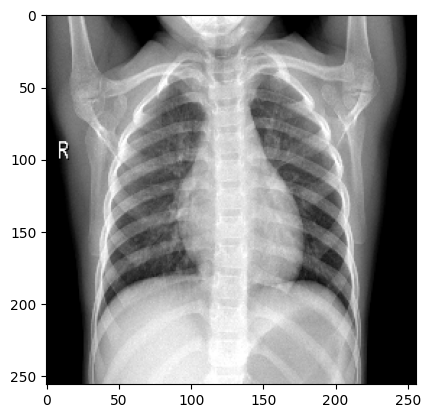

Training Set Image Label: [1. 0.]
Training Set Image Shape: (256, 256, 3)


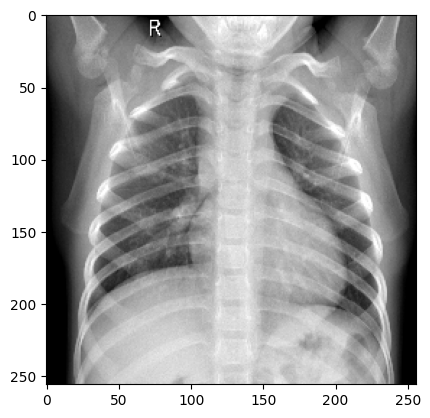

Training Set Image Label: [1. 0.]
Training Set Image Shape: (256, 256, 3)


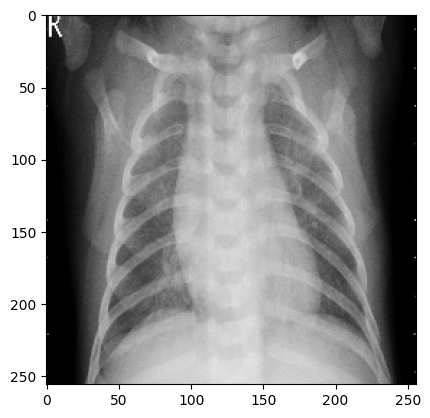

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


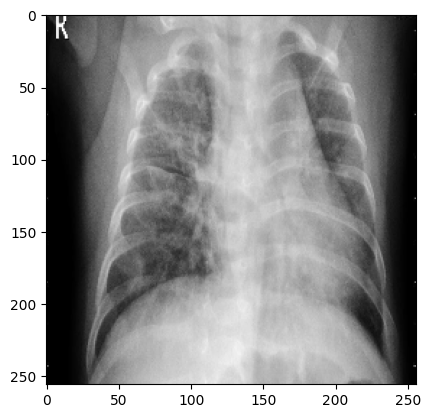

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


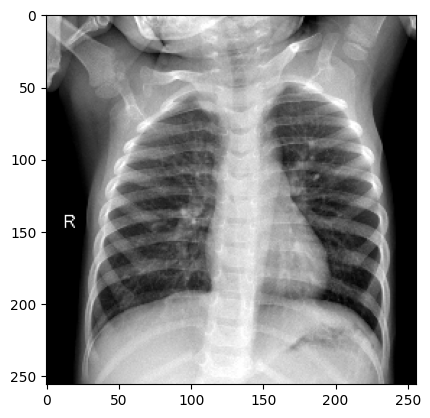

Training Set Image Label: [1. 0.]
Training Set Image Shape: (256, 256, 3)


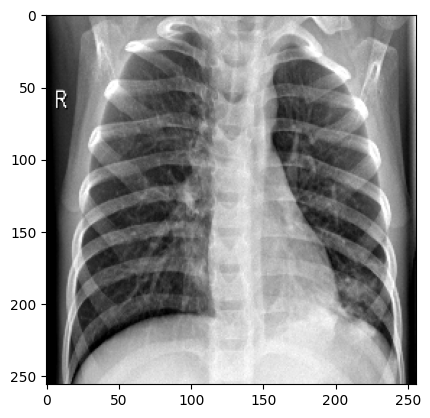

Training Set Image Label: [0. 1.]
Training Set Image Shape: (256, 256, 3)


In [6]:
# visualization of images from train set batch 1

import matplotlib.pyplot as plt

for i in range(1, 7):
    plt.imshow(train_images[i]/225.0)
    plt.show()
    print(F"Training Set Image Label: {train_labels[i]}")
    print(F"Training Set Image Shape: {train_images[i].shape}")


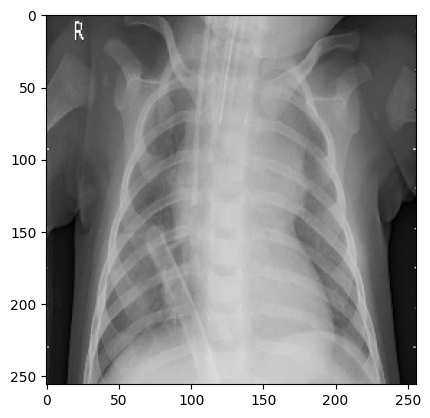

Test Set Image Label: [0. 1.]
Test Set Image Shape: (256, 256, 3)


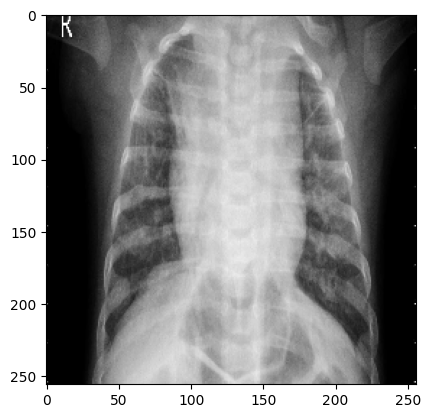

Test Set Image Label: [0. 1.]
Test Set Image Shape: (256, 256, 3)


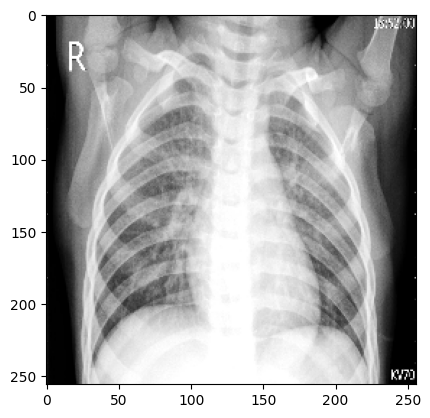

Test Set Image Label: [0. 1.]
Test Set Image Shape: (256, 256, 3)


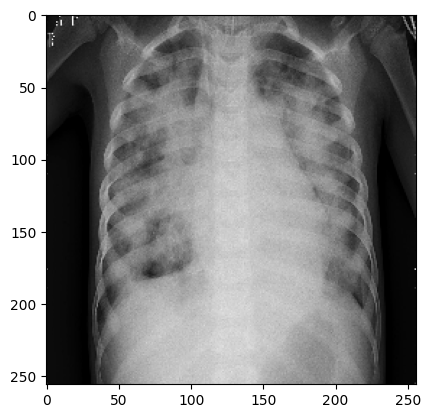

Test Set Image Label: [0. 1.]
Test Set Image Shape: (256, 256, 3)


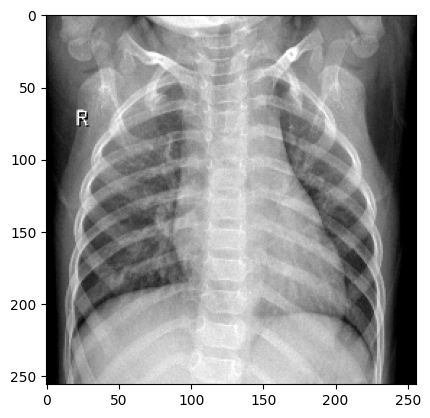

Test Set Image Label: [1. 0.]
Test Set Image Shape: (256, 256, 3)


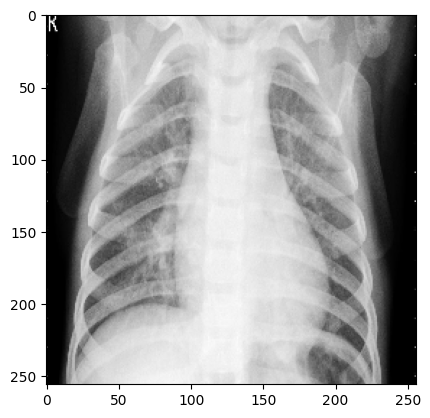

Test Set Image Label: [0. 1.]
Test Set Image Shape: (256, 256, 3)


In [7]:
test_set_elem = test_set.take(1)


for images, labels in train_set_elem:
    test_images = images.numpy()
    test_labels = labels.numpy()

# visualization of images from test set batch 1

for i in range(1, 7):
    plt.imshow(test_images[i]/225.0)
    plt.show()
    print(F"Test Set Image Label: {test_labels[i]}")
    print(F"Test Set Image Shape: {test_images[i].shape}")

The x-rays are not centered. The images are all rotatd at different angles.
Even though, the images look in the gray scale they have 3 channels.

The images don't seem to  have lot of information but because of the overlap of ribs and lungs, it could be difficult to extract features specific to the infection. A more complex model could maybe extract more features.

Given the differences between how the x-rays were taken, the images could be rotated at the very least as part of data augmentation.

# Build Models
## First Model: Simple CNN I

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 16, kernel_size = 3, activation = "relu", input_shape = (256, 256, 3),strides = 2))
cnn_model.add(MaxPooling2D(pool_size = 3, strides = 2))
cnn_model.add(Flatten())
cnn_model.add(Dense(16, activation = "relu"))
cnn_model.add(Dense(2))
cnn_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 127, 127, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 63504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │     1,016,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,016,562 (3.88 MB)

 Trainable params: 1,016,562 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits= True)
metrics = ["accuracy"]

cnn_model.compile(optimizer = opt, loss = loss, metrics = metrics)
cnn_model.fit(train_set_normalized, validation_data = validation_set_normalized,epochs = 5)

Epoch 1/5


I0000 00:00:1731863519.688472     977 service.cc:145] XLA service 0x7b54dc006600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731863519.688531     977 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731863519.688536     977 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 4/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6945 - loss: 10.0968

I0000 00:00:1731863522.588726     977 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 427ms/step - accuracy: 0.6503 - loss: 4.2634 - val_accuracy: 0.7629 - val_loss: 0.2783
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 419ms/step - accuracy: 0.7721 - loss: 0.3016 - val_accuracy: 0.9226 - val_loss: 0.2452
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 431ms/step - accuracy: 0.9371 - loss: 0.2389 - val_accuracy: 0.9168 - val_loss: 0.2694
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.9396 - loss: 0.1865 - val_accuracy: 0.9551 - val_loss: 0.1195
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 437ms/step - accuracy: 0.9511 - loss: 0.1309 - val_accuracy: 0.9646 - val_loss: 0.1054


Both the validation and training accuracies are quite high even though the model was trained for only 5 epochs. It is possible the model is overfitting. Adding regularization, data augmentation, and more fully-connected layers could help prevent some overfitting while still ensuring good performance.

## First Model: Simple CNN II

In [10]:
cnn_model_II = Sequential()

cnn_model_II.add(tf.keras.layers.RandomZoom(height_factor = 0.1))
cnn_model_II.add(tf.keras.layers.RandomRotation(factor = 0.2))

cnn_model_II.add(Conv2D(filters = 128, kernel_size = 5, activation = "relu", input_shape = (256, 256, 3),strides = 2))
cnn_model_II.add(MaxPooling2D(pool_size = 3, strides = 2))

cnn_model_II.add(Conv2D(filters = 256, kernel_size = 5, activation = "relu",strides = 2))
cnn_model_II.add(MaxPooling2D(pool_size = 3, strides = 2))

cnn_model_II.add(Flatten())

cnn_model_II.add(Dense(128, activation = "relu"))
cnn_model_II.add(Dropout(0.5))

cnn_model_II.add(Dense(64, activation = "relu"))
cnn_model_II.add(Dropout(0.5))

cnn_model_II.add(Dense(32, activation = "relu"))
cnn_model_II.add(Dropout(0.5))
cnn_model_II.add(Dense(2))

cnn_model_II.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training the Model

callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True)

opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits= True)
metrics = ["accuracy"]

cnn_model_II.compile(optimizer = opt, loss = loss, metrics = metrics)
cnn_model_II.fit(train_set_normalized, validation_data = validation_set_normalized,
                    callbacks = [callback], epochs = 15)

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 445ms/step - accuracy: 0.6471 - loss: 0.8261 - val_accuracy: 0.7629 - val_loss: 0.5624
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 478ms/step - accuracy: 0.7147 - loss: 0.6280 - val_accuracy: 0.7629 - val_loss: 0.5555
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 439ms/step - accuracy: 0.7205 - loss: 0.5796 - val_accuracy: 0.7629 - val_loss: 0.4995
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.7248 - loss: 0.5285 - val_accuracy: 0.7629 - val_loss: 0.4953
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 443ms/step - accuracy: 0.7260 - loss: 0.5233 - val_accuracy: 0.7639 - val_loss: 0.4922
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.7246 - loss: 0.5027 - val_accuracy: 0.7686 - val_loss: 0.3683
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 448ms/step - accuracy: 0.7594 - loss: 0.4283 - val_accuracy: 0.9044 - val_loss: 0.2849
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.8098 - loss: 0.3891 - val_accu

The architecture was modified a few times to try and reduce overfitting while still yielding reasonable performance. The experimentation included:

+ Trying different combinations of `data augmentation layers`.
+ Increasing the number of filters, trying different sizes, different strides, and number of convolutional layers.
+ Adding more fully-connected layers with a different number of units.
+ Removing `batch normalization` layers after the `fully-connected layers` and replacing them with `dropout layers`. Before this change, the model's performance was a bit erratic.
+ Reducing the `learning rate` helped the model to converge.
+ Adding a `callback` that would stop the training if the validation loss didn't decrease for three consecutive epochs. 
    + Using the `restore_best_weights` argument ensured that the model would use weights from the epoch with the lowest validation loss only.
    
## Second Model: Transfer Learning 

In [12]:

from tensorflow.keras import Model, Input,applications,layers, initializers
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = applications.resnet_v2.ResNet50V2(include_top=False,
                                               weights='imagenet',
                                               input_shape=(256, 256, 3))

base_model.trainable = False

input_layer = Input(shape=(256, 256, 3))

preprocessed_input_layer = applications.resnet_v2.preprocess_input(input_layer)
preprocessed_input_layer = layers.RandomZoom(height_factor=0.1)(preprocessed_input_layer)
preprocessed_input_layer = layers.RandomRotation(factor=0.2)(preprocessed_input_layer)

features_layer = base_model(preprocessed_input_layer, training=False)

global_pooling = GlobalAveragePooling2D()(features_layer)

fc1 = Dense(512)(global_pooling)
fc1 = layers.ReLU()(fc1)

fc2 = Dense(128)(fc1)
fc2 = layers.ReLU()(fc2)

fc3 = Dense(32)(fc2)
fc3 = layers.ReLU()(fc3)

output = Dense(2)(fc3)

second_model = Model(inputs=input_layer, outputs=output)

second_model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 256, 256, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 8, 8, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,683,746 (94.16 MB)

 Trainable params: 1,118,946 (4.27 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

second_model.compile(optimizer=opt, loss=loss, metrics=metrics)

second_model.fit(train_set, epochs=10, validation_data=validation_set, callbacks=[callback])

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 854ms/step - accuracy: 0.6931 - loss: 2.7783 - val_accuracy: 0.9388 - val_loss: 0.1930
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 637ms/step - accuracy: 0.9446 - loss: 0.1444 - val_accuracy: 0.9608 - val_loss: 0.1217
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 624ms/step - accuracy: 0.9509 - loss: 0.1320 - val_accuracy: 0.9178 - val_loss: 0.1897
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 625ms/step - accuracy: 0.9565 - loss: 0.1093 - val_accuracy: 0.9417 - val_loss: 0.1497
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 631ms/step - accuracy: 0.9636 - loss: 0.0977 - val_accuracy: 0.9551 - val_loss: 0.1325


In [14]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable=False

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

second_model.compile(optimizer=opt, loss=loss, metrics=metrics)

second_model.fit(train_set, epochs=5, validation_data=validation_set, callbacks=[callback])

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 754ms/step - accuracy: 0.9447 - loss: 0.1354 - val_accuracy: 0.9627 - val_loss: 0.1099
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 683ms/step - accuracy: 0.9629 - loss: 0.0926 - val_accuracy: 0.9665 - val_loss: 0.0966
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 671ms/step - accuracy: 0.9710 - loss: 0.0840 - val_accuracy: 0.9665 - val_loss: 0.0886
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 666ms/step - accuracy: 0.9803 - loss: 0.0653 - val_accuracy: 0.9656 - val_loss: 0.0904
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 673ms/step - accuracy: 0.9770 - loss: 0.0631 - val_accuracy: 0.9713 - val_loss: 0.0943


The `ResNet v2` architecture was selected since it was stated to be a better alternative to the original ResNet per the research paper.

We included the same data augmentation layers as the first model. Instead of flattening the layers, we used a global pooling average layer followed by three fully-connected layers and an output layer. We also included an early stopping callback like with the previous model.

We experimented with the number of layers to unfreeze for fine-tuning. Unfreezing layers beyond the last 10 either had diminishing returns or it worsened the model's performance.

The model doesn't seem to be overfitting given the added regularization and data augmentation, and the progression of the accuracy and loss values during training.

# Test Set Evaluation

In [17]:
first_model_test_loss, first_model_test_acc = cnn_model_II.evaluate(test_set_normalized)

print(f"Test set accuracy of first model: {first_model_test_acc}")

second_model_test_loss, second_model_test_acc = second_model.evaluate(test_set)

print(f"Test set accuracy of second model: {second_model_test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.8188 - loss: 0.3838
Test set accuracy of first model: 0.8189102411270142
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step - accuracy: 0.8426 - loss: 0.4541
Test set accuracy of second model: 0.8413461446762085


# Conclusion

The second model, using transfer learning, outperforms the first model. The test set accuracies of both the models are not much lower than that their respective validation accuracies. That can be considered a good sign that the model probably isn't overfitting.

The accuracy of either of the models is not high enough to be suitable for a medical diagnosis, in our opinion. However, the second model with some more training and experimentation is likely to yield better performance given the lack of additional data.